In [1]:
### Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import seaborn as sns

### Layout

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(font_scale=3,palette=sns.color_palette('colorblind'), 
        rc={'axes.facecolor':'white'},color_codes=False)
sns.set_style(style="ticks",rc={"xtick.direction": "in","ytick.direction": "in",
                                "xtick.minor.size": 4, "ytick.minor.size": 4})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
births = pd.read_csv('data/births.csv')

In [3]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


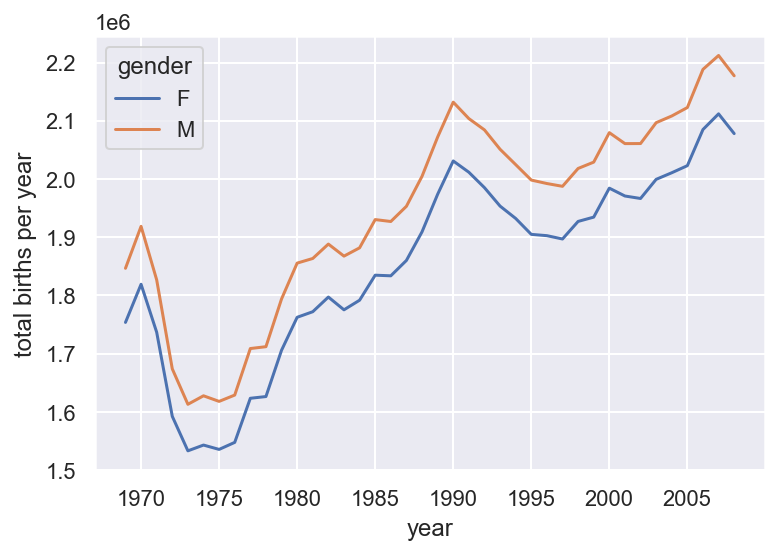

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

In [5]:
mu, sig = births.births.mean(),births.births.std()

births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')


In [6]:
# create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d', errors='coerce')

births['dayofweek'] = births.index.dayofweek

In [7]:
births = births.dropna()



In [8]:
births_by_date = births.pivot_table('births', index=[births.index.month, births.index.day], dropna=True)

births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

In [9]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]

/Users/koppelman/opt/anaconda3/envs/gold/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


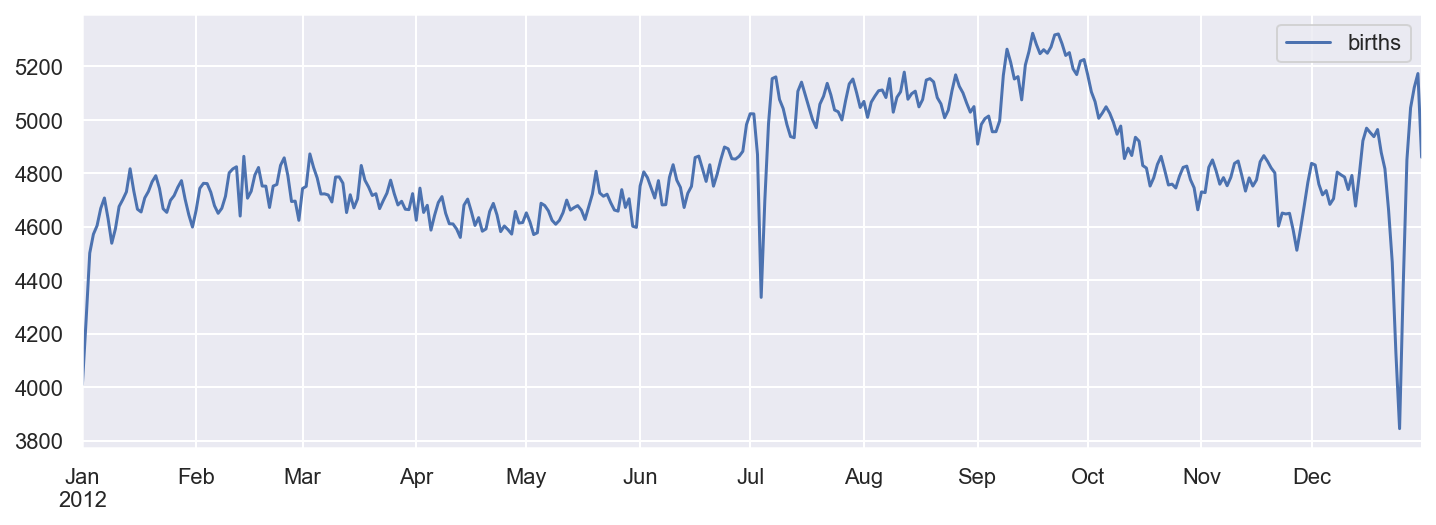

In [10]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

# Gaussian Process - Simple

In [11]:
days = births_by_date.index

In [12]:
X = births_by_date.index
X = (X - X.min()).days
X = X.to_numpy(dtype=np.int64)
X = X[:,np.newaxis]

In [13]:
y = births_by_date.births.values
# y -= y.mean()

In [14]:
X.shape, y.shape

((366, 1), (366,))

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel, RationalQuadratic



In [16]:
# Based on:
# https://scikit-learn.org/stable/modules/gaussian_process.html#gpr-on-mauna-loa-co2-data

In [17]:
gp_kernel = (  RBF(length_scale=80)  # A long-term smooth component
             
             # short-term periodic component with decay
             + ExpSineSquared(length_scale=2, periodicity=7) * RBF(length_scale=30) 

             # flexible mid-term component; can account for variable lenghts
             + RationalQuadratic(alpha=7, length_scale=1)
             
             # Correlated (RBF) & uncorrelated (White) noise
             + RBF(length_scale=0.5)
             + WhiteKernel(noise_level=0.5)

            )

gpr = GaussianProcessRegressor(kernel=gp_kernel, 
                               random_state = 3,
                               n_restarts_optimizer=10, 
                               normalize_y=True)
gpr.fit(X, y)

GaussianProcessRegressor(kernel=RBF(length_scale=80) + ExpSineSquared(length_scale=2, periodicity=7) * RBF(length_scale=30) + RationalQuadratic(alpha=7, length_scale=1) + RBF(length_scale=0.5) + WhiteKernel(noise_level=0.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=3)

In [18]:
gpr.kernel_

RBF(length_scale=65.3) + ExpSineSquared(length_scale=2.88e+03, periodicity=15.6) * RBF(length_scale=1e+05) + RationalQuadratic(alpha=2.85e+04, length_scale=65.3) + RBF(length_scale=2.35) + WhiteKernel(noise_level=0.0422)

In [19]:
X_plot = np.linspace(-100,500,500)[:,np.newaxis]

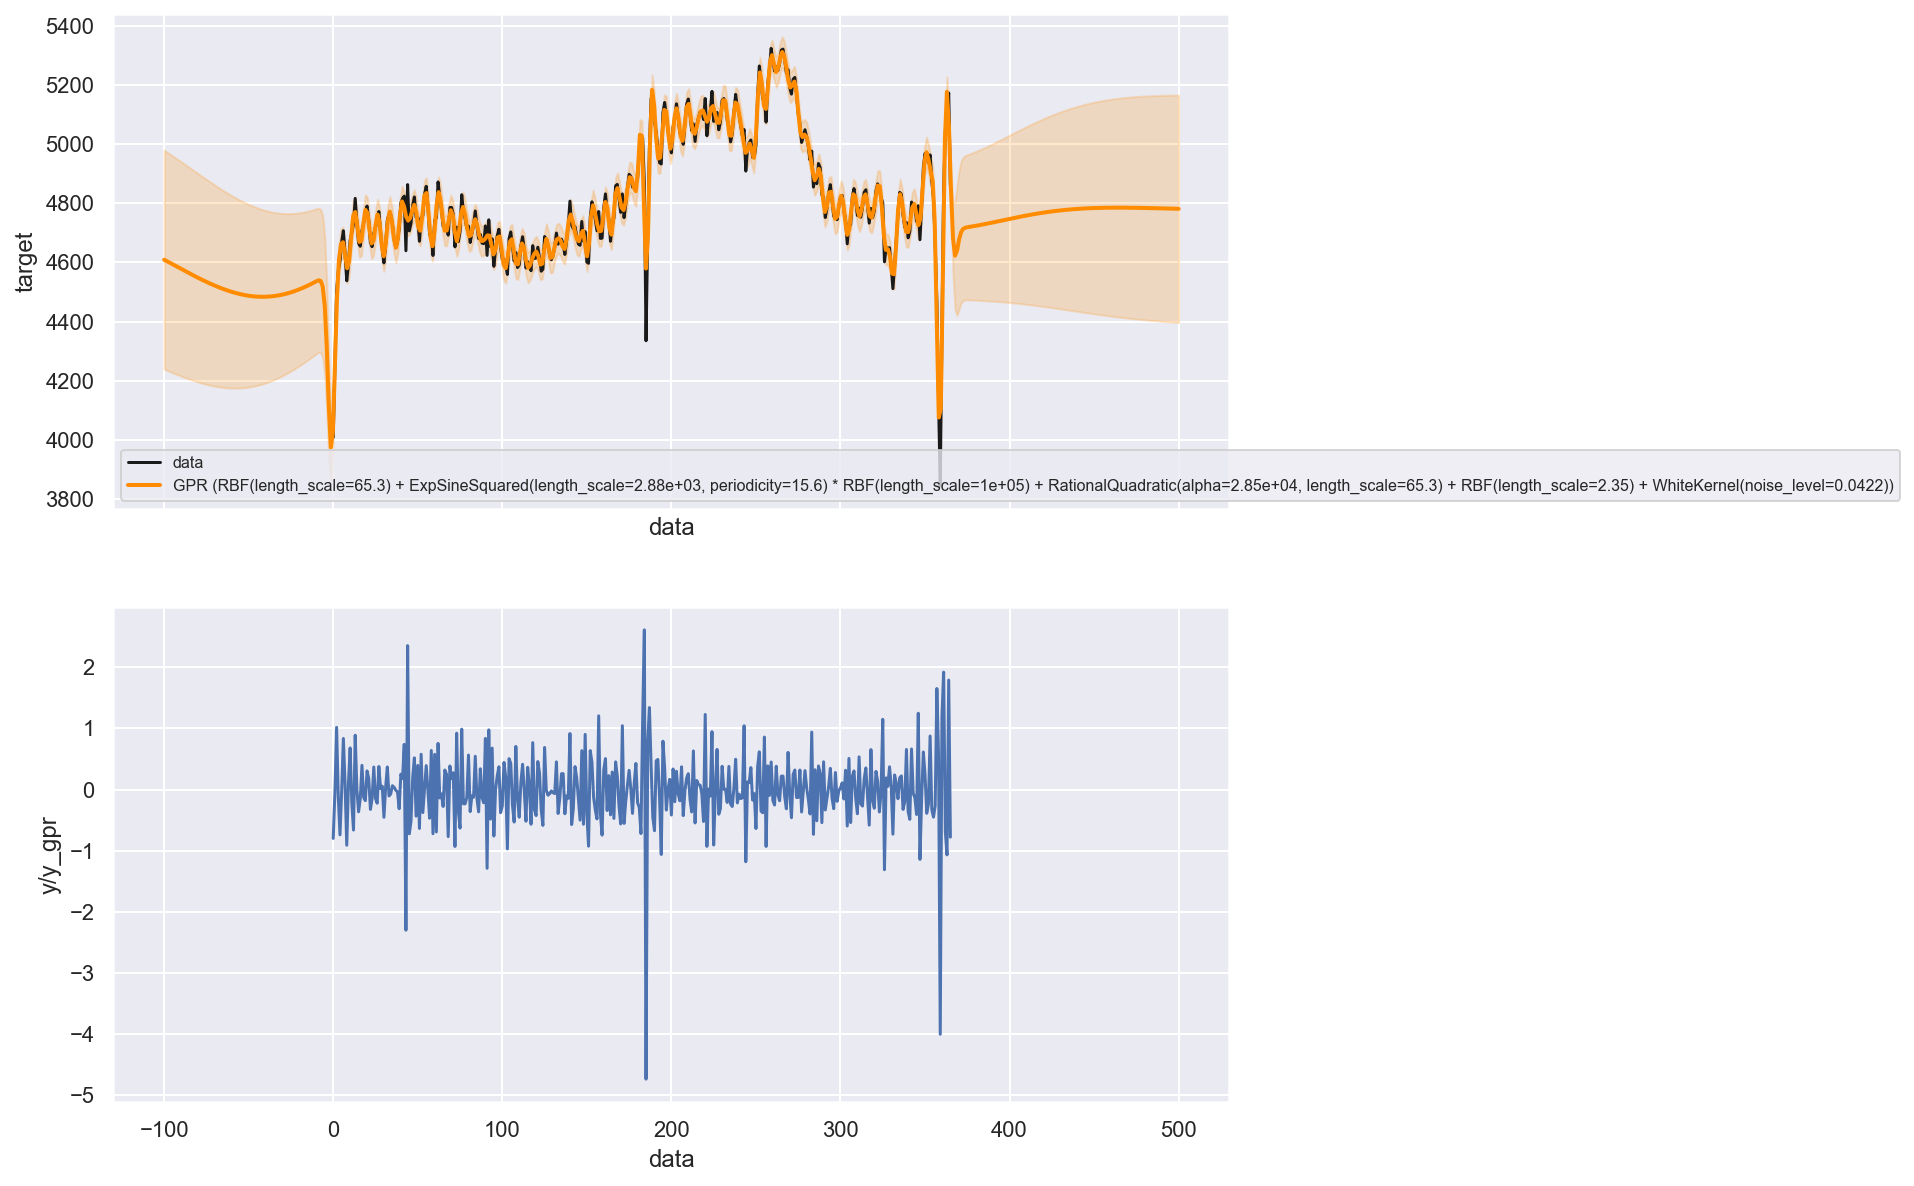

In [20]:
# Plot results
fig, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)

plt.sca(ax[0])
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
plt.plot(X, y, c='k', label='data')
plt.plot(X_plot, y_gpr, color='darkorange', lw=2,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')

plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})

plt.sca(ax[1])

y_gpr, y_std = gpr.predict(X, return_std=True)

plt.plot(X, (y - y_gpr)/y_std, )
plt.xlabel('data')
plt.ylabel('y/y_gpr')

plt.show()

In [21]:
days[np.abs((y - y_gpr)/y_std)>2]

DatetimeIndex(['2012-02-13', '2012-02-14', '2012-07-03', '2012-07-04',
               '2012-12-25'],
              dtype='datetime64[ns]', freq=None)

Valentines day, Labor day, and Christmas are messing up the fitting.  
Also the first day of the year is clearly an outlier. Let's remove these and repeat.

### Refitting without outliers

In [22]:
days = births_by_date.index

In [23]:
outliers = np.array(['2012-01-01', '2012-02-14', '2012-07-04', '2012-12-25', '2012-12-24'], dtype=np.datetime64)

In [24]:
mask = ~np.in1d(days, outliers)

In [25]:
X = births_by_date.index
X = (X - X.min()).days
X = X.to_numpy(dtype=np.int64)
X = X[mask,np.newaxis]

In [26]:
y = births_by_date.births.values[mask]
# y -= y.mean()

In [27]:
X.shape, y.shape

((361, 1), (361,))

In [28]:
gp_kernel = (  
             # A long-term smooth component
             RBF(length_scale=80)  
             
             # short-term periodic component with decay
             + ExpSineSquared(length_scale=2, periodicity=7) * RBF(length_scale=30) 

             # flexible mid-term component; can account for variable lenghts
             + RationalQuadratic(alpha=7, length_scale=1)
             
             # Correlated (RBF) & uncorrelated (White) noise
             + RBF(length_scale=0.5)
             + WhiteKernel(noise_level=0.5)

            )

gpr = GaussianProcessRegressor(kernel=gp_kernel, 
                               random_state = 3,
                               n_restarts_optimizer=10, 
                               normalize_y=True)
gpr.fit(X, y)

GaussianProcessRegressor(kernel=RBF(length_scale=80) + ExpSineSquared(length_scale=2, periodicity=7) * RBF(length_scale=30) + RationalQuadratic(alpha=7, length_scale=1) + RBF(length_scale=0.5) + WhiteKernel(noise_level=0.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=3)

In [29]:
gpr.kernel_

RBF(length_scale=65) + ExpSineSquared(length_scale=1e+05, periodicity=14.2) * RBF(length_scale=1e+05) + RationalQuadratic(alpha=125, length_scale=65.5) + RBF(length_scale=2.65) + WhiteKernel(noise_level=0.0314)

In [30]:
X_plot = np.linspace(-100,500,500)[:,np.newaxis]

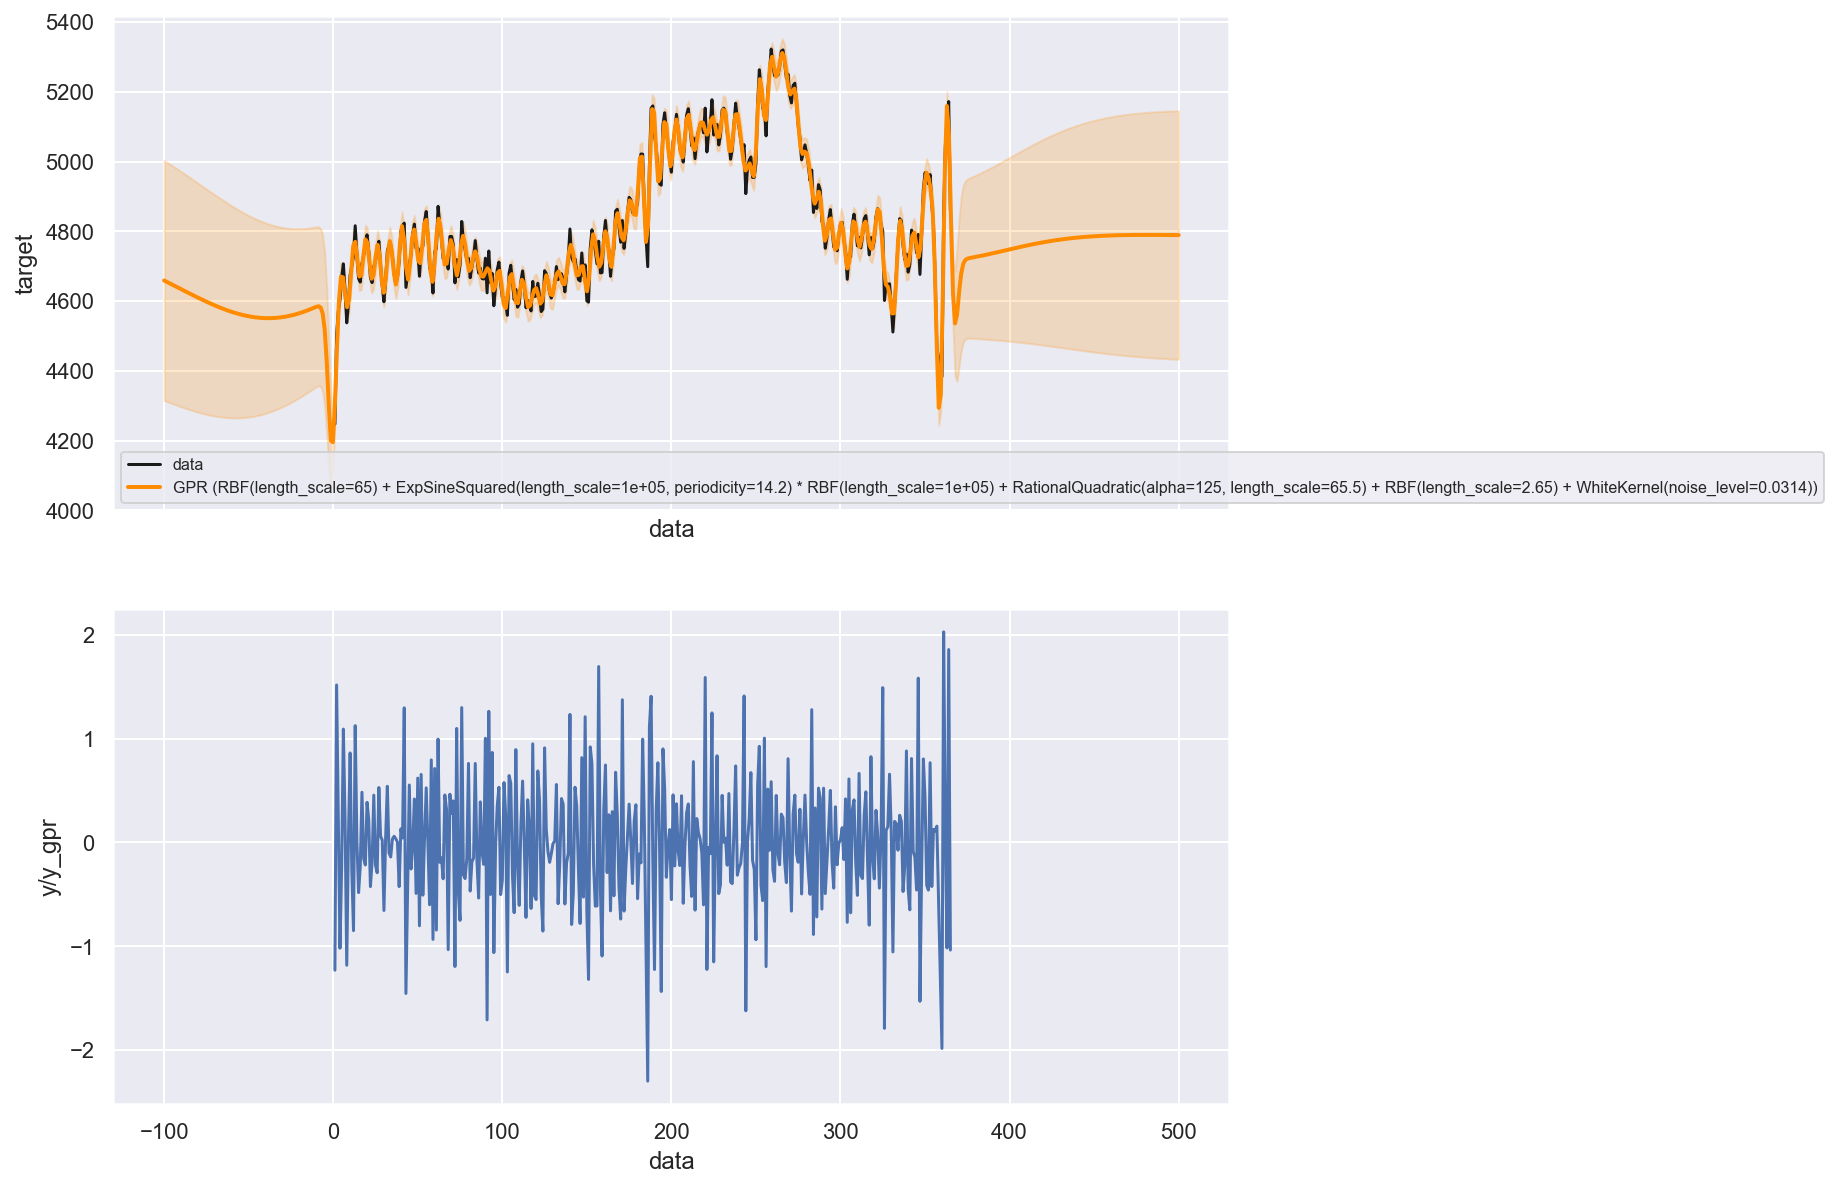

In [31]:
# Plot results
fig, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True)

plt.sca(ax[0])
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
plt.plot(X, y, c='k', label='data')
plt.plot(X_plot, y_gpr, color='darkorange', lw=2,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')

plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})

plt.sca(ax[1])

y_gpr, y_std = gpr.predict(X, return_std=True)

plt.plot(X, (y - y_gpr)/y_std, )
plt.xlabel('data')
plt.ylabel('y/y_gpr')

plt.show()